In [1]:
# !pip install captcha
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, to_pil_image

from captcha.image import ImageCaptcha
from tqdm import tqdm
import random
import numpy as np
from collections import OrderedDict
import string


In [2]:
characters = '-' + string.digits + string.ascii_uppercase
width, height, n_len, n_classes = 192, 64, 4, len(characters)
n_input_length = 12
print(characters, width, height, n_len, n_classes)

-0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ 192 64 4 37


In [3]:
class CaptchaDataset(Dataset):
    def __init__(self, characters, length, width, height, input_length, label_length):
        super(CaptchaDataset, self).__init__()
        self.characters = characters
        self.length = length
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        random_str = ''.join([random.choice(self.characters[1:]) for j in range(self.label_length)])
        image = to_tensor(self.generator.generate_image(random_str))
        target = torch.tensor([self.characters.find(x) for x in random_str], dtype=torch.long)
        input_length = torch.full(size=(1, ), fill_value=self.input_length, dtype=torch.long)
        target_length = torch.full(size=(1, ), fill_value=self.label_length, dtype=torch.long)
        return image, target, input_length, target_length

TRP8 tensor([12]) tensor([4])


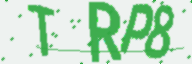

In [4]:
dataset = CaptchaDataset(characters, 1, width, height, n_input_length, n_len)
image, target, input_length, label_length = dataset[0] # X： img, y:index in characters
print(''.join([characters[x] for x in target]), input_length, label_length)
to_pil_image(image)

In [5]:
batch_size = 128
train_set = CaptchaDataset(characters, 1000 * batch_size, width, height, n_input_length, n_len)
valid_set = CaptchaDataset(characters, 100 * batch_size, width, height, n_input_length, n_len)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=12)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=12)

In [6]:
class Model(nn.Module):
    def __init__(self, n_classes, input_shape=(3, 64, 192)):
        super(Model, self).__init__()
        self.input_shape = input_shape
        channels = [32, 64, 128, 256, 256]
        layers = [2, 2, 2, 2, 2]
        pools = [2, 2, 2, 2, (2, 1)]

        def block(num_convs, in_channels, out_channels):
            lys = []
            for _ in range(num_convs):
                lys.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=(1, 1)))
                lys.append(nn.BatchNorm2d(out_channels))
                lys.append(nn.ReLU(inplace=True))
                in_channels = out_channels
            return nn.Sequential(*lys)

        convs_blks = []
        last_channels = 3
        for  (num_convs, out_channels, k_pool) in zip( layers, channels, pools):
            convs_blks.append(block(num_convs, last_channels,out_channels))
            last_channels = out_channels
            convs_blks.append(nn.MaxPool2d(k_pool))
        
        self.cnn = nn.Sequential(*convs_blks,nn.Dropout(0.25, inplace=True),)
        self.lstm = nn.LSTM(input_size=self.infer_features(), hidden_size=128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)
    
    def infer_features(self):
        x = torch.zeros((1,)+self.input_shape)
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        return x.shape[1]

    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [7]:
model = Model(n_classes, input_shape=(3, height, width)).cuda()
inputs = torch.zeros((32, 3, height, width)).cuda()
outputs = model(inputs)
outputs.shape

torch.Size([12, 32, 37])

In [8]:
model

Model(
  (cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2,

In [9]:
def decode(sequence):
    a = ''.join([characters[x] for x in sequence])
    s = ''.join([x for j, x in enumerate(a[:-1]) if x != characters[0] and x != a[j+1]])
    if len(s) == 0:
        return ''
    if a[-1] != characters[0] and s[-1] != a[-1]:
        s += a[-1]
    return s

def decode_target(sequence):
    return ''.join([characters[x] for x in sequence]).replace(' ', '')

def calc_acc(target, output):
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    target = target.cpu().numpy()
    output_argmax = output_argmax.cpu().numpy()
    a = np.array([decode_target(true) == decode(pred) for true, pred in zip(target, output_argmax)])
    return a.mean()

In [10]:
def train(model, optimizer, epoch, dataloader):
    model.train()
    loss_mean = 0
    acc_mean = 0
    with tqdm(dataloader) as pbar:
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            
            output_log_softmax = F.log_softmax(output, dim=-1)
            # oneflow的fucntional中没有，需要从nn导入CTCLss类
            ctc = nn.CTCLoss()
            loss = ctc(output_log_softmax, target, input_lengths, target_lengths)    
            
            loss.backward()
            optimizer.step()

            loss = loss.item()
            acc = calc_acc(target, output)
            
            if batch_index == 0:
                loss_mean = loss
                acc_mean = acc
            
            loss_mean = 0.1 * loss + 0.9 * loss_mean
            acc_mean = 0.1 * acc + 0.9 * acc_mean
            
            pbar.set_description(f'Epoch: {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

def valid(model, optimizer, epoch, dataloader):
    model.eval()
    with tqdm(dataloader) as pbar, torch.no_grad():
        loss_sum = 0
        acc_sum = 0
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()
            
            output = model(data)
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            
            loss = loss.item()
            acc = calc_acc(target, output)
            
            loss_sum += loss
            acc_sum += acc
            
            loss_mean = loss_sum / (batch_index + 1)
            acc_mean = acc_sum / (batch_index + 1)
            
            pbar.set_description(f'Test : {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 1e-2, amsgrad=True)
epochs = 15
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

In [13]:
model.load_state_dict(torch.load('model_torch'))
#torch.save(model.state_dict(),'model_torch')

<All keys matched successfully>

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4, amsgrad=True)
epochs = 15
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

true: 4MUX
tensor([[[  2.8546,  -3.3523,  -8.1717,  -6.0708,  -4.0418,  16.0312,  -8.0979,
           -2.4576, -10.6805,   2.6182,  -5.0918,   3.0840,  -0.6392,  -6.3725,
           -2.1209,  -2.1172, -10.6574, -10.7217,  -8.6657,  -8.1083,  -3.2643,
           -3.7789,   2.7096,   3.1574,   1.9283,  -2.4664, -12.9124,   1.4534,
           -6.2626,  -5.7662, -12.9197,   4.0866,   0.5735,  -2.7820,  -9.0809,
           -7.9188,  -2.7079],
         [ 14.5446,  -3.0817,  -6.5121,  -5.6061,  -7.9660,  -2.7975,  -9.2164,
           -4.9302,  -5.4549,  -7.4886,  -9.9128,  -6.7527,  -5.8944,  -3.9659,
           -2.8875,  -4.0548, -10.0428,  -7.3941, -11.1321,  -1.4836,  -7.1216,
           -6.7376,  -1.2444,  -2.8674,  -5.5471,  -3.9984, -11.1611,  -0.9924,
           -9.1141,  -7.9214,  -4.2944,  -4.2064,  -4.1631,  -8.0232,  -9.5459,
          -10.5319,  -2.9244],
         [ -0.0927,  -1.4174,  -2.0833,  -8.2076,  -2.3230,  -2.8816,  -8.0734,
           -7.9226,  -2.8705, -10.0026,  -5.839

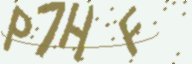

In [20]:
#
model.eval()
do = True
while do or decode_target(target) == decode(output_argmax[0]):
    do = False
    image, target, input_length, label_length = dataset[0]


    
    print('true:', decode_target(target))

    output = model(image.unsqueeze(0).cuda())
    
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    print(output.detach().permute(1, 0, 2))
    print('pred:', decode(output_argmax[0]))
to_pil_image(image)

- 修改模型代码风格
 - 输入打包
- 修改训练函数、准确率计算函数
